In [14]:
# import relevant modules

import pandas as pd
import numpy as np
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from music21 import converter, instrument, note,chord, stream
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

In [15]:
midi_list = ['All Too Well.mid','All the Small Things.mid', 'Beauty and the Beat.mid','Breakaway.mid','Cant Feel My Face.mid','Dont Matter.mid','Dont Stop Believing.mid','Falling Slowly.mid', 'Hallelujah.mid','Halo.mid','Im Yours.mid','Imagine.mid','Let It Be.mid','Purpose.mid','Somewhere Out There.mid','Stay With Me.mid','Stronger.mid','Sunday Morning.mid','We Belong Together.mid','When I was Your Man.mid']

In [16]:
# Store all midi files and their parts into one list, respectively

all_midis = []
all_parts = []

for song in midi_list:
    midi = converter.parse('midi_songs/' + song)
    for i in midi.parts:
        i.insert(0, instrument.Piano())
    parts = instrument.partitionByInstrument(midi)

    all_midis.append(midi)
    all_parts.append(parts)


In [17]:
# Store all notes, their offset, and their durations

notes = []
notes_offset = []
durations = []

for parts in all_midis:
    for i in parts.recurse():
        if isinstance(i, note.Note):
            notes.append(str(i.pitch))
            notes_offset.append(float(i.offset))
            durations.append(float(i.duration.quarterLength))

        elif isinstance(i, chord.Chord):
            notes_offset.append(float(i.offset))
            durations.append(float(i.duration.quarterLength))
            
            i = str(i).replace('>', '')
            chords = '|'.join(i.split()[1:])
            notes.append(chords)
            

In [18]:
# Set the sequence length to 100 notes

sequence_length = 100
allnotes = sorted(set(i for i in notes))

In [19]:
# Create a note to index dictionary like word to index dictionary in text generator

note_index_dic = dict((note, index) for index, note in enumerate(allnotes)) 

In [20]:
# Store Prepare the notes input by slicing and concatenating notes with the sequence length of 100 

notes_input = []
notes_output = []
n_words = len(set(notes))

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i: i + sequence_length]
    sequence_out = notes[i + sequence_length]
    
    notes_input.append([note_index_dic[note] for note in sequence_in])
    notes_output.append(note_index_dic[sequence_out])

In [21]:
# Turn the sliced notes into an array form for processing

notes_input = np.array(notes_input).reshape(len(notes_input),  sequence_length, 1)
notes_output = np_utils.to_categorical(notes_output)

In [22]:
notes_input = notes_input / float(n_words)

In [23]:
# Create an LSTM model

model = Sequential()
model.add(LSTM(
    512,
    input_shape=(notes_input.shape[1], notes_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_words))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

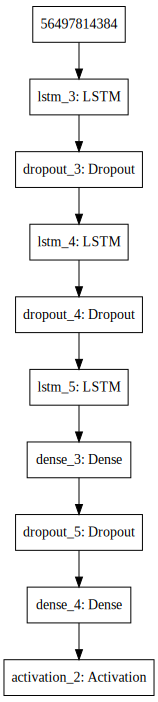

In [24]:
# visualizing the model

SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [25]:
model.fit(notes_input, notes_output, epochs = 20, batch_size = 64)


KeyboardInterrupt: 

In [33]:
start = np.random.randint(0, len(notes_input))

In [34]:
# Recreate the music using the dictionary 

int_to_note = dict((index, note) for index, note in enumerate(allnotes))

In [35]:

start_music = notes_input[start]
prediction_output = []

In [37]:
start_music

array([[0.0546875],
       [0.0546875],
       [0.5859375],
       [0.0546875],
       [0.0546875],
       [0.359375 ],
       [0.1953125],
       [0.0546875],
       [0.1953125],
       [0.359375 ],
       [0.359375 ],
       [0.0546875],
       [0.1953125],
       [0.359375 ],
       [0.359375 ],
       [0.46875  ],
       [0.46875  ],
       [0.3984375],
       [0.25     ],
       [0.5390625],
       [0.703125 ],
       [0.703125 ],
       [0.25     ],
       [0.5390625],
       [0.703125 ],
       [0.703125 ],
       [0.2890625],
       [0.2890625],
       [0.7109375],
       [0.7109375],
       [0.2890625],
       [0.2890625],
       [0.7109375],
       [0.7109375],
       [0.2890625],
       [0.2890625],
       [0.7109375],
       [0.7109375],
       [0.2890625],
       [0.2890625],
       [0.7109375],
       [0.7109375],
       [0.0078125],
       [0.0078125],
       [0.0078125],
       [0.0078125],
       [0.8203125],
       [0.8203125],
       [0.8203125],
       [0.7109375],


In [38]:
# Store the note predictions

prediction_output = []

for note_index in range(4):
    prediction_input = np.reshape(start_music, (1, len(start_music), 1))
    prediction_input = prediction_input / float(n_words)
    prediction = model.predict(prediction_input, verbose = 0)

    index = np.argmax(prediction)
    result = int_to_note[index]
    
    prediction_output.append(result)
    
    start_music = list(start_music)
    start_music.append(index)
    start_music = start_music[1: len(start_music)]
    


    
    

In [39]:
prediction_output

['C5', 'C5', 'C5', 'C5']

In [1]:
# Add offset, instrument, stream

offset= 0
output_notes = []
for pattern in prediction_output:
    new_note = note.Note(pattern)
    new_note.offset = offset
    new_note.storedInstrument = instrument.Piano()
    output_notes.append(new_note)
    offset += .5
    
midi_stream = stream.Stream(output_notes)

NameError: name 'prediction_output' is not defined

In [35]:
for i in midi_stream.recurse():
    print(i, i.offset)

<music21.stream.Stream 0xd37bf0b70> 0.0
<music21.note.Note E-> 0.0
<music21.note.Note E-> 0.5
<music21.note.Note E-> 1.0
<music21.note.Note E-> 1.5


In [37]:
# Store the music 

midi_stream.write('midi', fp= 'lstm.midi')

'lstm.midi'